In [36]:
# Step 1 - Load preprocessing outputs and set up environment
# Put this at the top of 03_KNN.ipynb


%run "./02_preprocessing.ipynb"
# this line runs the complete preprocessing notebook itself

# 2) Imports we'll use in this notebook
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import joblib

# 3) Quick sanity prints so you know everything is loaded
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test  distribution:\n", y_test.value_counts(normalize=True))
print("\nPreprocessor type:", type(preprocessor))


Initial shape: (15000, 17)
Exact duplicate rows: 0
Duplicate faculty_id: 0


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,department_collaboration,promotion_opportunities,publications_last_3_years,student_evaluation_avg,job_market_alternatives,left_institution
0,1,Associate Professor,Tenure-Track,3,70974.758663,6,9960.082453,Community College,Medium,1,3,8,1,7,3.520074,9,0
1,2,Full Professor,Non-Tenure,16,69482.774557,3,108309.536130,Liberal Arts College,Medium,3,3,2,9,4,3.811163,4,0
2,3,Lecturer,Non-Tenure,19,91434.392986,2,10044.468010,Research University,Medium,9,5,9,3,4,3.539667,7,0
3,4,Associate Professor,Non-Tenure,24,65850.710135,6,4159.726828,Research University,Small,5,7,6,1,5,4.351417,9,1
4,5,Associate Professor,Non-Tenure,39,30000.000000,7,10718.111809,Community College,Small,6,6,8,8,5,3.932108,2,0


Train shape: (12000, 15)
Test shape: (3000, 15)

Train target distribution:
left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type', 'department_size']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'admin_support', 'work_life_balance', 'department_collaboration', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg', 'job_market_alternatives']
Preprocessor fitted successfully!
Processed shape: (12000, 40)
X_train shape: (12000, 15)
X_test  shape: (3000, 15)
y_train distribution:
 left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64
y_test  distribution:
 left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64

Preprocessor type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>


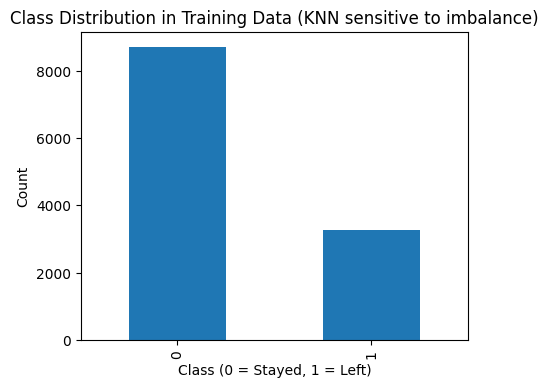

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution in Training Data (KNN sensitive to imbalance)")
plt.xlabel("Class (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()


Running PCA for 2D visualization...


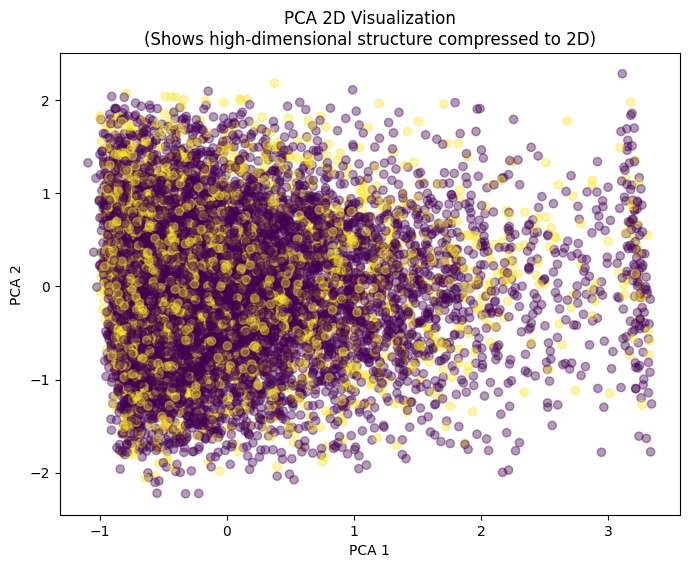

In [40]:
# ============================
# PART 2.3 — PCA Visualization
# ============================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Running PCA for 2D visualization...")

# ---------------------------------------------------------
# STEP 1 — Transform training data using the preprocessor
# ---------------------------------------------------------
# Preprocessor applies:
# • Scaling
# • OneHotEncoding
# • Missing/outlier flags
# • All your preprocessing pipeline steps
X_train_processed = preprocessor.transform(X_train)

# ---------------------------------------------------------
# STEP 2 — Convert sparse → dense (if needed)
# ---------------------------------------------------------
# OneHotEncoder often outputs sparse matrices.
# PCA may not accept sparse format.
if hasattr(X_train_processed, "toarray"):
    X_train_dense = X_train_processed.toarray()
else:
    X_train_dense = X_train_processed

# ---------------------------------------------------------
# STEP 3 — Apply PCA (reduce ~40D → 2D)
# ---------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_dense)

# ---------------------------------------------------------
# STEP 4 — Plot PCA scatter
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],         # PCA 1 on x-axis
    X_pca[:, 1],         # PCA 2 on y-axis
    c=y_train,           # Color by class (0 or 1)
    alpha=0.4
)

plt.title("PCA 2D Visualization\n(Shows high-dimensional structure compressed to 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()




Running improved KNN...


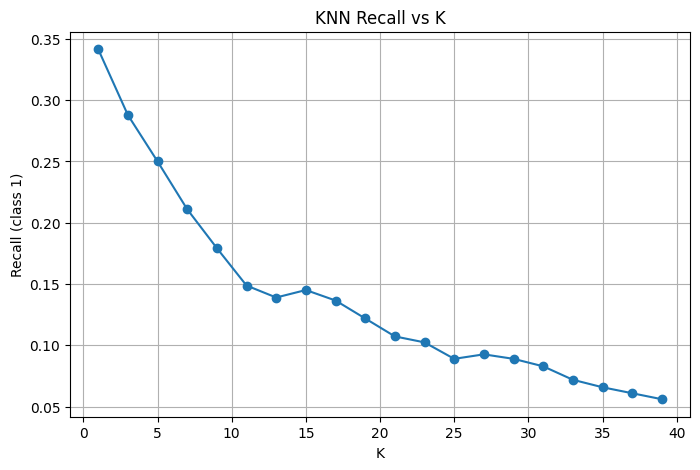

Best K (based on Recall) = 1


In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

k_values = list(range(1, 41, 2))  # odd numbers from 1 to 39
recalls = []
accuracies = []

print("Running improved KNN...")

for k in k_values:

    # Correct: only THIS pipeline must be used
    model = Pipeline([
        ("preprocess", preprocessor),
        ("knn", KNeighborsClassifier(
            n_neighbors=k,
            weights='distance',
            metric='minkowski',
            p=1
        ))
    ])
    
    # Fit on TRAIN data
    model.fit(X_train, y_train)
    
    # Predict on TEST data
    y_pred = model.predict(X_test)
    
    # Store metrics
    recalls.append(recall_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot recall curve
plt.figure(figsize=(8,5))
plt.plot(k_values, recalls, marker='o')
plt.title("KNN Recall vs K")
plt.xlabel("K")
plt.ylabel("Recall (class 1)")
plt.grid(True)
plt.show()

print("Best K (based on Recall) =", k_values[recalls.index(max(recalls))])


Accuracy (K=11): 0.7283333333333334
AUC: 0.6739250950995749

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84      2180
           1       0.51      0.15      0.23       820

    accuracy                           0.73      3000
   macro avg       0.63      0.55      0.53      3000
weighted avg       0.68      0.73      0.67      3000



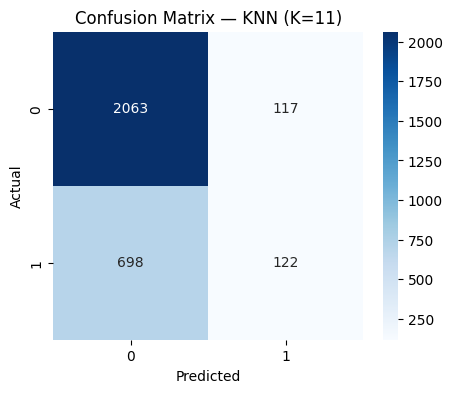

In [47]:
# ============================================
# FINAL BASELINE KNN (Using stable K = 11)
# ============================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

best_stable_k = 11   # chosen after analyzing elbow but avoiding unstable K=1

knn_final = Pipeline([
    ("preprocess", preprocessor),
    ("knn", KNeighborsClassifier(
        n_neighbors=best_stable_k,
        weights="distance",
        metric="minkowski",
        p=1
    ))
])

# Train
knn_final.fit(X_train, y_train)

# Predict
y_pred_knn = knn_final.predict(X_test)
y_prob_knn = knn_final.predict_proba(X_test)[:, 1]

print(f"Accuracy (K={best_stable_k}):", accuracy_score(y_test, y_pred_knn))
print("AUC:", roc_auc_score(y_test, y_prob_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — KNN (K={best_stable_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Training Final KNN Model with SVD...

Final KNN With SVD — Performance:
Accuracy: 0.735
AUC: 0.6776644663235624

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84      2180
           1       0.58      0.11      0.19       820

    accuracy                           0.73      3000
   macro avg       0.66      0.54      0.52      3000
weighted avg       0.70      0.73      0.66      3000



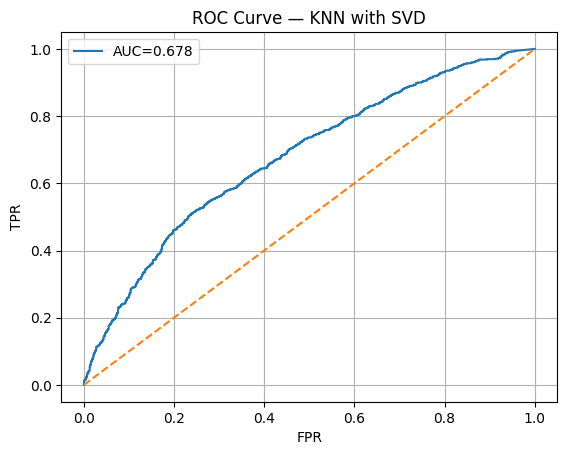

In [46]:
# ============================================
# FINAL KNN WITH TRUNCATED SVD (Recommended)
# ============================================

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

print("Training Final KNN Model with SVD...")

knn_svd = Pipeline([
    ("preprocess", preprocessor),
    
    # Reduce dimensionality after OHE (very important!)
    ("svd", TruncatedSVD(
        n_components=40,      # reduce to 40 latent dimensions
        random_state=42
    )),
    
    ("knn", KNeighborsClassifier(
        n_neighbors=15,
        weights="distance",
        metric="minkowski",
        p=1                    # Manhattan distance
    ))
])

# Train
knn_svd.fit(X_train, y_train)

# Predict
y_pred_svd = knn_svd.predict(X_test)
y_prob_svd = knn_svd.predict_proba(X_test)[:, 1]

print("\nFinal KNN With SVD — Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svd))
print("AUC:", roc_auc_score(y_test, y_prob_svd))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svd))

# ROC Curve (optional)
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob_svd)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob_svd):.3f}")
plt.plot([0,1], [0,1], '--')
plt.title("ROC Curve — KNN with SVD")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()
